# RAG LLM Medical Chatbot System 
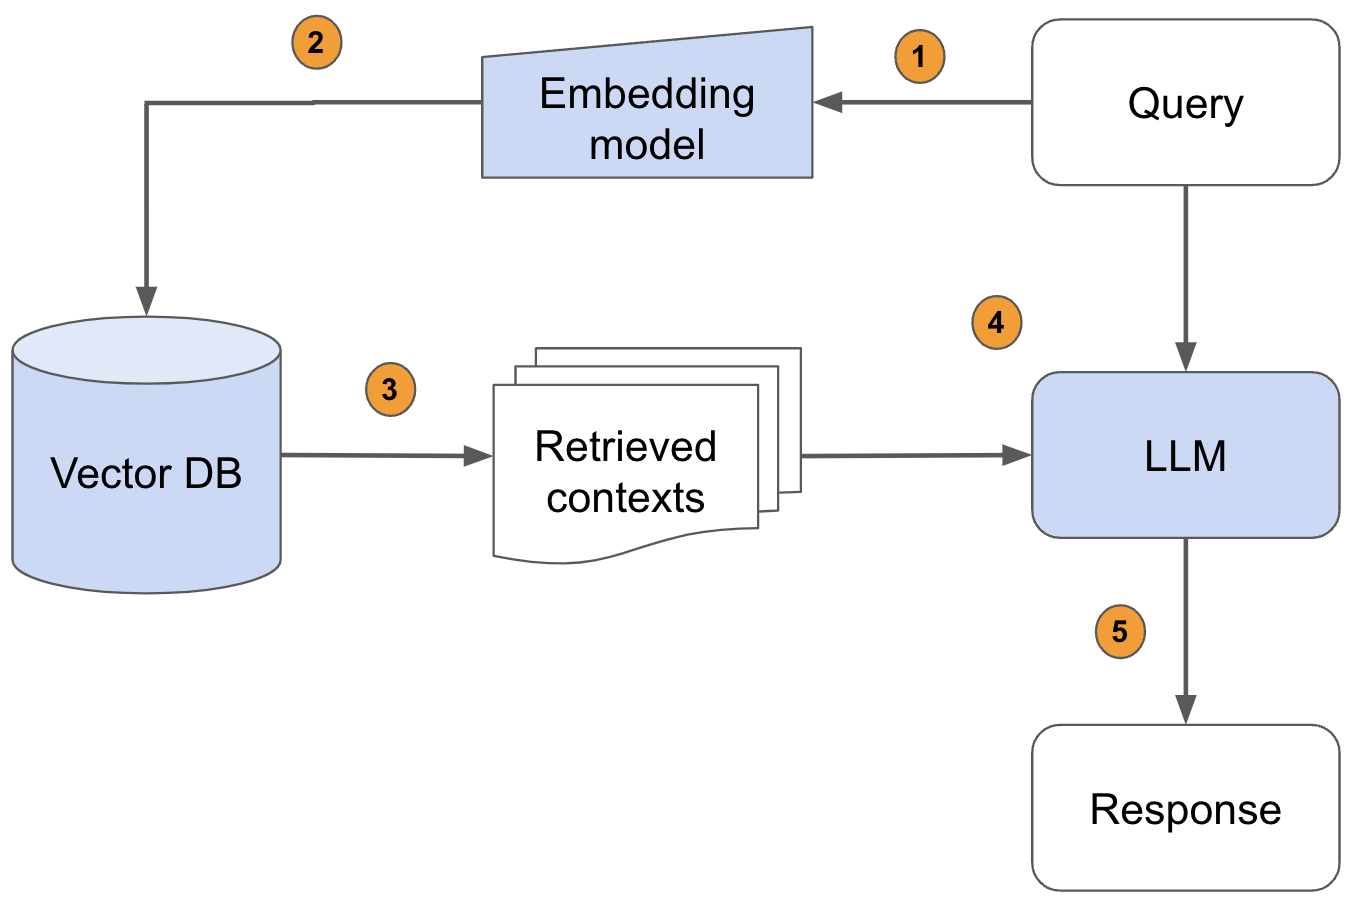

In [42]:
!pip install -q pypdf
!pip install -q langchain openai faiss-cpu tiktoken
!pip install -q pypdf
!pip install -q sentence-transformers
!pip install -q ctransformers

In [1]:
PDF_PATH = '71763-gale-encyclopedia-of-medicine.-vol.-1.-2nd-ed.pdf' 

# Generating the Vector Database 
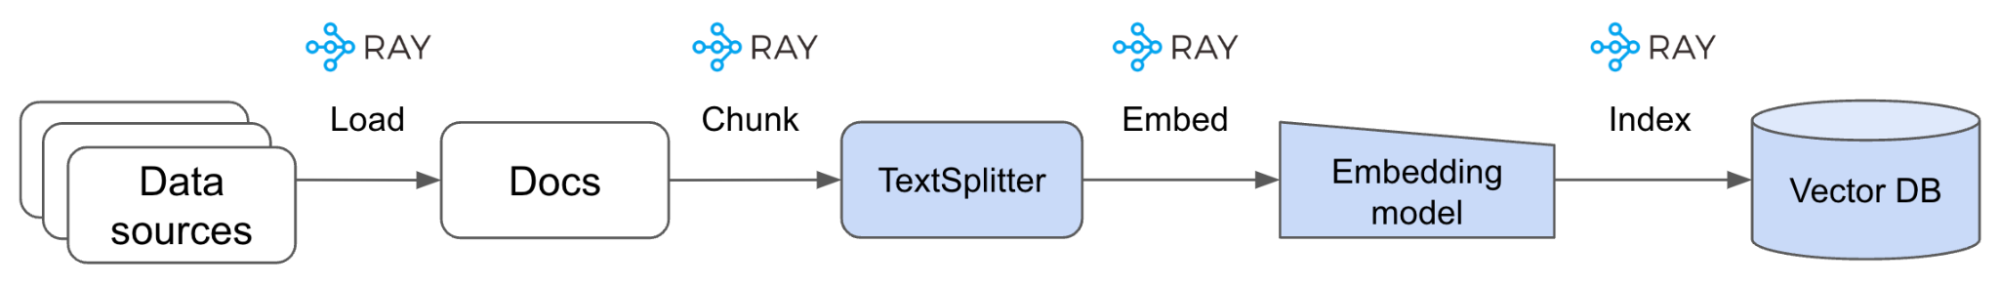

## Loading Data 

In [28]:
import matplotlib.pyplot as plt 
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate
from langchain.chains import RetrievalQA , ConversationChain
from langchain.llms import CTransformers
from langchain.chains.conversation.memory import ConversationBufferMemory

In [4]:

loader = PyPDFLoader(PDF_PATH)
pages = loader.load_and_split()

In [13]:
pages[20]

Document(page_content='under most types of major medical insurance. As always,\nthough, the patient would be wise to confirm that theircoverage extends to the specific procedure proposed. Fornonemergency situations, most underwriters stipulateprior approval as a condition of coverage.\nSpecific conditions for which ultrasound may be\nselected as a treatment option—certain types of tumors,lesions, kidney stones and other calculi, muscle and lig-\nament injuries, etc.—are described in detail under theappropriate entries in this encyclopedia.\nPreparation\nA patient undergoing abdominal ultrasound will be\nadvised by their physician about what to expect and howto prepare. As mentioned above, preparations generallyinclude fasting and arriving for the procedure with a fullbladder, if necessary. This preparation is particularly use-ful if the gallbladder, ovaries or veins are to be examined.\nAftercare\nIn general, no aftercare related to the abdominal\nultrasound procedure itself is require

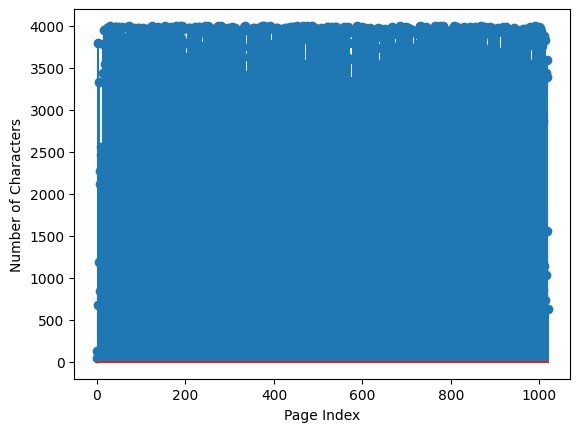

In [23]:
num_chars = []
for i, page in enumerate(pages):
    num_chars.append(len(page.page_content))

plt.stem(range(len(num_chars)), num_chars)
plt.xlabel("Page Index")
plt.ylabel("Number of Characters")
plt.show()

## Chunking Data 

In [64]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text splitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
)

# Chunk a sample section
sample_section = pages[200]
chunks = text_splitter.create_documents(
    texts=[sample_section.page_content], 
    metadatas=[{"source": sample_section.metadata}])


In [65]:
print(len(chunks))
print(chunks[1])

20
page_content='mine receptors on nasal tissue, decreasing the effect ofhistamine release by mast cells. They may be used aftersymptoms appear, though they may be even more effec-tive when used preventively, before symptoms appear. Awide variety of antihistamines are available.' metadata={'source': {'source': '71763-gale-encyclopedia-of-medicine.-vol.-1.-2nd-ed.pdf', 'page': 126}}


In [66]:
texts = text_splitter.split_documents(pages)


## Embed Data 

In [6]:
def get_embedding_model(model_name ,model_kwargs ):
    embedding_model = HuggingFaceEmbeddings(
            model_name = model_name,  # also works with model_path
            model_kwargs = model_kwargs)
    return embedding_model

## Store in Vector Database 
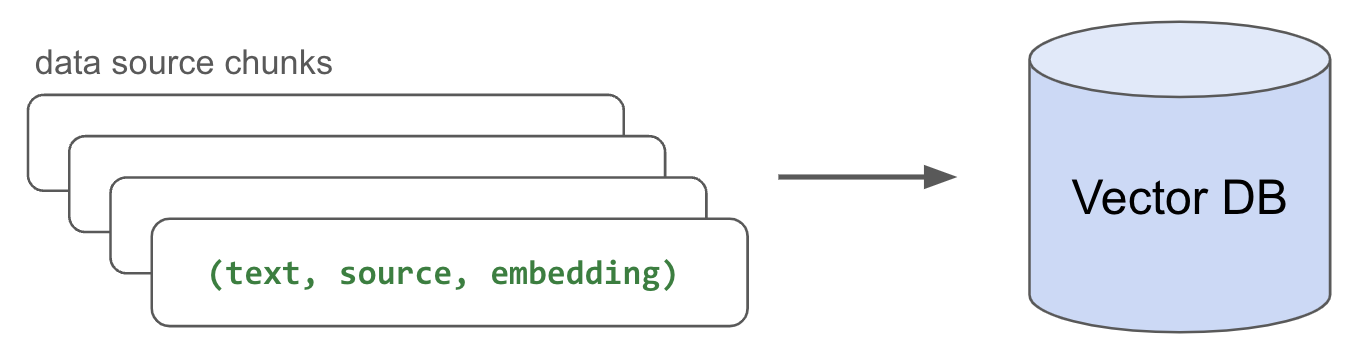

In [67]:
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2" 
embedding_model = get_embedding_model(embedding_model_name ,
                                      model_kwargs={'device': 'cpu'} ,
                                      # model_kwargs={'device': 'cuda'}
                                     )

In [68]:
DB_FAISS_PATH = "VectorStore/db_faiss"
db = FAISS.from_documents(texts, embedding_model)
db.save_local(DB_FAISS_PATH)

## Retrieval with respect to Query 
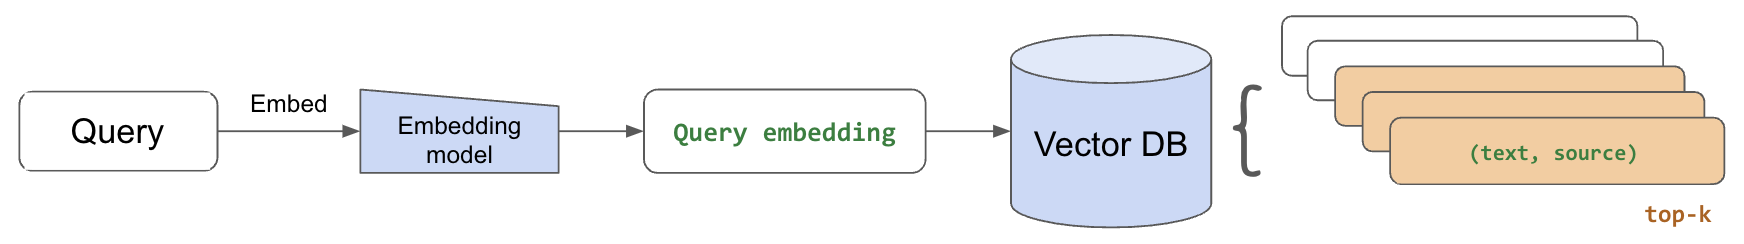

In [69]:
DB_FAISS_PATH = "VectorStore/db_faiss"
db = FAISS.load_local(DB_FAISS_PATH, embedding_model)

In [16]:
retriever = db.as_retriever()


In [17]:
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain.vectorstores.faiss.FAISS object at 0x7fadfaa8b1f0>)

In [70]:
query = "The left leg seems broken , Is it some kind of fracture I have"
docs = db.similarity_search(query , k=5)

In [71]:
docs

[Document(page_content='GALE ENCYCLOPEDIA OF MEDICINE 2 607Bruises\nA close-up view of woman’s bruised left eye. (Custom Med-\nical Stock Photo. Reproduced by permission.)GEM -0433 to 0624 - B  10/22/03 6:09 PM  Page 607', metadata={'source': '71763-gale-encyclopedia-of-medicine.-vol.-1.-2nd-ed.pdf', 'page': 620}),
 Document(page_content='ness, loss of speech, or blindness.\n• In the femoral (leg) arteries: Disease of the blood ves-\nsels in the outer parts of the body ( peripheral vascular\ndisease ) causes cramping and fatigue in the calves\nwhen walking.\n• In the renal (kidney) arteries: High blood pressure that\nis difficult to treat.', metadata={'source': '71763-gale-encyclopedia-of-medicine.-vol.-1.-2nd-ed.pdf', 'page': 407}),
 Document(page_content='tion of uric acid crystals in the joint), tiny fractures of a\nbone in the foot (stress fractures), or infection and mayorder additional tests to rule out these possibilities.\nTreatment\nConservative\nThe first step in treating a b

## Generation
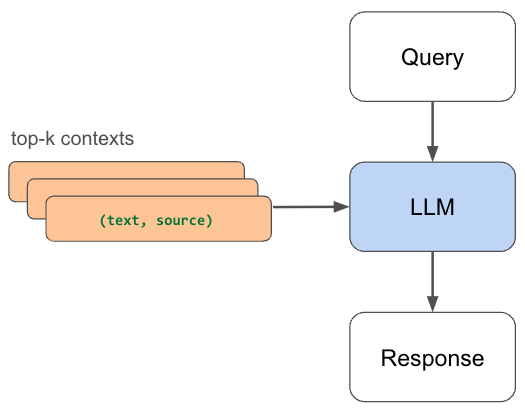

In [72]:

custom_prompt_template = """You are an AI doctor 
Use the following pieces of information to simulate a doctor pateint conversation with the user's question.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct.
If you don't know the answer, just say that you don't know and ask them to refer a clinical expert, don't try to make up an answer.

Context: {context}
Question: {question}

Guide the user to gain further information on his condition in relation to his Question 
Helpful answer:
"""

def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt


In [73]:
len(custom_prompt_template) + len("I drank and now I am hangover , prescribe me something")

588

In [87]:
def load_llm():
    # Load the locally downloaded model here
    llm = CTransformers(
        model = "TheBloke/Llama-2-7B-Chat-GGML",
        model_type="llama",
        max_new_tokens = 1024,
        temperature = 0
    )
    return llm

In [43]:
def retrieval_qa_chain(llm, prompt, db):
    qa_chain = RetrievalQA.from_chain_type(llm=llm,
                                       chain_type='stuff',
                                       retriever=db.as_retriever(search_kwargs={'k': 2}),
                                       return_source_documents=True,
                                       chain_type_kwargs={'prompt': prompt}
                                       )
    return qa_chain

In [75]:
llm = load_llm()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [76]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever= db.as_retriever(search_kwargs={'k': 5}),
    chain_type_kwargs={'prompt': set_custom_prompt()}
)


In [79]:
qa.run("I am feeling nauseous and I am unable to sleep,can you help me " )

'The first step in treating nausea and vomiting is to identify and treat any underlying cause. This may involve a thorough medical evaluation, including blood tests and imaging studies to rule out any serious underlying conditions.\nIf the nausea and vomiting are caused by a viral or bacterial infection, antibiotics or antiviral medications may be prescribed to help manage symptoms.\nIn addition, there are several non-pharmacological interventions that can help manage nausea and vomiting ,such as relaxation techniques, acupuncture, ginger, and peppermint tea.\nIt is important to note that these remedies may not be recommended by healthcare professionals and should not replace medical advice from a qualified healthcare professional '

In [85]:
qa.run("suggest me remedies for runny nose")

'You are experiencing a lot of congestion and your nose is running.  You might consider some alternative treatments that can help you feel better. There are many natural remedies that can help alleviate your symptoms. Here are some suggestions for remedies that may be helpful to try:\n1. Nasal irrigation or a neti pot can help clear out any excess mucus in your nose and sinuses.\n2.\nUnlike salineffective salt water,\nUnfortunately, 2.\nUnlike saline,\nUnlike saline.\nUnlike turmerid=\nUnlike saline. Steamongeliminute.\nUnlike a saline, If you might help thin out with salt water oralmondiherbalance to your health can also known as it is a saline. 2. A humid=2.Drink,You could be helpful inhalloveget into your nasalongeliminate a neti.\nUnlike saline.\nUnfortunately for instance. It can help soaking of antihoney. Steamoxy,\nUnlike salt water oralready?  \nUnlike saline is'